# TP1 : Linear regression

Notes : Z score en valeur abs 


The purpose of this work is to implement least square linear regression to medical data. The problem is based on an example described in the book by Hastie & Tibshirani (2009) pp. 3-4 & 49-63. Data come from a study published by Stamey et al. (1989). This study aims at the **prediction of the level of prostate specific antigen, denoted by `lpsa` below**, from the
results of clinical exams. These exams are carried out before a possible
prostatectomy.

The measurements are log cancer volume `lcavol`, log prostate 
weight `lweight`, age of the patient `age`, log of benign prostatic 
hyperplasia amount `lbph`, seminal vesicle invasion `svi`, log of capsular 
penetration `lcp`, Gleason score `gleason`, and percent of Gleason scores 4 or 
5 `pgg45`. The variables `svi` and `gleason` are categorical, others are
quantitative. There are `p=8` entries.
The work is decomposed in the following tasks:

* read and format the data : extraction of the training and test sets,
* apply least square regression method to predict `lpsa` from the entries,
* study the estimated error on the test set (validation),
* identify the most significant entries by using a rejection test,
* apply regularized least square regression method (ridge regression),
* search for an optimal regularization parameter thanks to
cross-validation.

In [2]:
import csv
# import os
from pylab import *
import numpy as np
from numpy import linalg as la

import pandas as pd
import seaborn as sns

## Read & Normalize data
Data are stored in ASCII format: 

* the first column enumerates the data from 1 à 97 (97 male subjects). 
* columns 2 to 9 contain the entries themselves. 
* column 10 contains target values. 
* column 11 contains label 1 for the training set, 
and 2 for the test set.

In [3]:
#%% To read data from spaced separated float numbers
# x, y = np.loadtxt(c, delimiter=',', usecols=(0, 2), unpack=True)

data_init = np.loadtxt('prostate_data_sansheader.txt')

data = data_init[:,1:]   # we get rid of the indices (1 to 97)

#%% Extraction of training/test sets
Itrain = np.nonzero(data[:,-1]==1)
data_train=data[Itrain]   # original data

Itest = np.nonzero(data[:,-1]==0)
data_test = data[Itest]   # original data

**Normalization of the data** *with respect to the mean and standard deviation of the training set*.

In [4]:
M_train = data_train
M_test = data_test 
moy = np.zeros((8,))
sigma = np.zeros((8,))

# With a FOR loop :
for k in range(8): # 8 columns of entries
    moy[k]=np.mean(data_train[:,k])
    sigma[k] = np.std(data_train[:,k], ddof=0)
    M_train[:,k] = (data_train[:,k]-moy[k])/sigma[k] # normalized: centered, variance 1
    M_test[:,k] = (data_test[:,k]-moy[k])/sigma[k]   # same normalization for test set

print(sigma)

[ 1.23328245  0.47303067  7.44601122  1.45269103  0.41684299  1.39024269
  0.70355366 29.08227243]


In [5]:
# Alternative WITHOUT FOR
""" normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function 
M_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST
moy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )
sigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )

M_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T"""

' normalize = lambda vec: (vec-np.mean(vec))/np.std(vec)    # inline function \nM_train = np.array( [ normalize(vec) for vec in data_train[:,0:8].T ] ).T  # iterate on vec direct / ARRAY not LIST\nmoy = np.array( [ np.mean(vec) for vec in data_train[:,0:8].T ] )\nsigma = np.array( [ np.std(vec, ddof=0) for vec in data_train[:,0:8].T ] )\n\nM_test = np.array([ (data_test[:,k]-moy[k])/sigma[k] for k in range(M_train.shape[1]) ] ).T'

In [6]:
M_train.shape

(67, 10)

# Part 1 : simple least square regression

## Preliminary questions
 
 * Compute the autocovariance matrix from the training set.
 * Observe carefully & Comment. What kind of information can you get ? 

[[ 1.          0.30023199  0.28632427  0.06316772  0.59294913  0.69204308
   0.42641407  0.48316136  0.87888041]
 [ 0.30023199  1.          0.31672347  0.43704154  0.18105448  0.15682859
   0.02355821  0.07416632  0.58165878]
 [ 0.28632427  0.31672347  1.          0.28734645  0.12890226  0.1729514
   0.36591512  0.27580573  0.27288962]
 [ 0.06316772  0.43704154  0.28734645  1.         -0.1391468  -0.08853456
   0.03299215 -0.03040382  0.31520031]
 [ 0.59294913  0.18105448  0.12890226 -0.1391468   1.          0.67124021
   0.30687537  0.48135774  0.66757572]
 [ 0.69204308  0.15682859  0.1729514  -0.08853456  0.67124021  1.
   0.47643684  0.66253335  0.58643947]
 [ 0.42641407  0.02355821  0.36591512  0.03299215  0.30687537  0.47643684
   1.          0.7570565   0.41049032]
 [ 0.48316136  0.07416632  0.27580573 -0.03040382  0.48135774  0.66253335
   0.7570565   1.          0.53710401]
 [ 0.87888041  0.58165878  0.27288962  0.31520031  0.66757572  0.58643947
   0.41049032  0.53710401  1.43

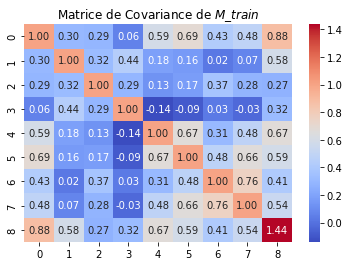

In [6]:
# Numériquement
covar_train = np.cov(M_train[:, :-1], rowvar=False, bias=True)
# bias = True, pour avoir des 1 sur la diagonale. Concrètement, on utilise un estimateur biaisé (/n) plutôt qu'un estimateur non biaisé (/(n-1)).
# On ne prends pas en compte la dernière colonne de M_train car ce sont les labels. 
# rowvar = False, équivalent à utiliser la transposée, chaque colonne représente une variable et chaque ligne une observation. 

print(covar_train)

# Graphiquement
sns.heatmap(covar_train, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Covariance de $M$_$train$')
plt.show()

### Observations 
> * On obtient bien des 1 sur la diagonale pour les correlations des variables (variance = 1). 
> * Les huit premières colonnes (ou lignes) représentent la corrélation des variables entre elles.
> > * Les variables semblent globalement peu corrélées entre elles, mais attention tout de même à certaines variables qui ont une correlation parfois > 0.7 (par exemple entre la variable 6 et 7).
> * La dernière colonne (ou ligne) représente les corrélations des variables avec la cible. Aucune variable ne semble être décorrelé à la cible, ce qui montre que nos variables actuelles pourraient être un indicateur important pour la prédiction de la cible.

Quelques rappels à propos de la notion de covariance : https://fr.wikipedia.org/wiki/Covariance

## Exercise 1 : least square regression 
 * Build the matrix of features `X_train` for the training set, the first column is made of ones.
 * Estimate the regression vector `beta_hat` (estimates= `X*beta_hat`)
 _Indication: you may either use the function `inv` or another more efficient way to compute $A^{-1}B$ (think of `A\B`)._ 
 * What is the value of the first coefficient `beta_hat[0]` ? What does it correspond to ?
 * Estimate the prediction error (quadratic error) from the test set.


*Indication: be careful of using `X_test` defined above, normalized w.r.t. the training data set. You can estimate this error by using:*

In [12]:
t_test = data_test[:,8]   # target column
N_test = data_test.shape[0]
X_test = np.concatenate((np.ones((N_test,1)), M_test[:,0:8]), axis=1) 
# don't forget the 1st column of ones and normalization !

In [18]:
# Exercise 1

# X_train
t_train = data_train[:,8]
N_train = data_train.shape[0]
X_train = np.concatenate((np.ones((N_train, 1)), M_train[:, 0:8]), axis=1)

# beta hat
beta_hat = la.pinv(X_train).dot(t_train)
print("beta_hat = ",beta_hat[0])

# error estimate 
y_pred_test = X_test @ beta_hat

# Quadratic error
quadratic_error = np.mean((t_test - y_pred_test) ** 2)
print('quadratic error : ',quadratic_error)


beta_hat =  2.452345085074627
quadratic error :  0.5212740055076002


> beta_hat[0] est l'ordonnée à l'origine du modèle de regression linéaire. C'est la valeur moyenne de la cible dans l'ensemble d'entraînement
>
> En moyenne, nous faisons une erreur au sens des moindres carrés d'environ 0.521 pour une valeure prédite de **lpsa** de 2.452. 

## Rejection test, computation of Z-scores
Now we turn to the selection of the most significant entries so that our predictor be more robust. The essential idea is that our estimates will be more robust if only the most significant entries are taken into account. As a consequence, note that we will *reduce the dimension* of the problem from |p=8| to some smaller dimension. The present approach uses a statistical test to decide whether the regression coefficient corresponding to some entry is significantly non-zero. Then we can decide either to put non significant coefficients to zero, or to select the significant entries only and estimate the new reduced regression vector.

Let's assume that target values are noisy due to some white Gaussian
noise with variance $\sigma^2$ (see Hastie & Tibshirani p. 47). One can show that the estimated regression vector |beta_hat| is also Gaussian with variance

$$ var (\widehat{\beta}) = (X^TX)^{-1}\sigma^2.$$  

One can also show that the estimator of the variance (from the training set)

$$\widehat{\sigma^2}=\frac{1}{(N-p-1)}\sum (t_n-\widehat{t}_n)^2$$

obeys a Chi-2 distribution. As a consequence a Chi-square statistical test can be used to determine whether some coefficient $\beta_j$ is
significantly non-zero. To this aim, one defines the variables $z_j$
named Z-scores which in turn obey a Fisher law, also called
$t$-distribution, which are often used in statistics:

$$ z_j = \frac{\beta_j}{\widehat{\sigma}\sqrt{v_j}} $$

where $v_j$ is the $j$-th diagonal element of the matrix $(X^TX)^{-1}$.
For sake of simplicity, we will consider that the null hypothesis of
$\beta_j$ is rejected with probability 95% if the Z-score is greater than 2.

## Exercise 2
1. Compute the Z-scores and select the most significant entries.
2. Estimate the prediction error over the test set if only these significant 
entries are taken into account for regression by putting other regression 
coefficients to zero.
3. Estimate the new regression vector when only the significant features
are taken into account.
4. Compare to previous results (Exercise 1).

*Indication 1 : to sort a vector `Z` in descending order*
`val = np.sort(np.abs(Z))[-1:0:-1]`


*Indication 2 :* to extract the diagonal of a matrix,
`vXX = np.diag(inv(X.T.dot(X),k=0)`

In [23]:
# Exercise 2

# Question 1
cov_beta = la.inv(X_train.T @ X_train) # covariance de beta_hat
std_errors = np.sqrt(np.diag(cov_beta))
z_scores = beta_hat / std_errors

# Sort Z-scores in descending order of their absolute values
sorted_indices = np.argsort(np.abs(z_scores))[::-1]
sorted_z_scores = z_scores[sorted_indices]
z_scores_and_indices = np.column_stack((sorted_indices, sorted_z_scores))

print(z_scores_and_indices)

array([[ 0.        , 20.07330964],
       [ 1.        ,  3.82233398],
       [ 2.        ,  1.95934898],
       [ 5.        ,  1.75881608],
       [ 4.        ,  1.46435022],
       [ 6.        , -1.32977588],
       [ 8.        ,  1.23783904],
       [ 3.        , -0.99428653],
       [ 7.        , -0.10447898]])

In [27]:
# Question 2/3

threshold = 2

beta_hat_significant = beta_hat.copy() # copy of beta_hat for modification
beta_hat_significant[np.abs(z_scores) < threshold] = 0

y_pred_test_significant = X_test @ beta_hat_significant

quadratic_error_significant = np.mean((t_test - y_pred_test_significant) ** 2)
print("erreur quadratique avec z-score: ",quadratic_error_significant) 

X_train_significant = X_train[:, np.abs(z_scores) >= threshold]
beta_hat_new = la.inv(X_train_significant.T @ X_train_significant) @ X_train_significant.T @ M_train[:, 8]

print("Nouveau beta_hat : ",beta_hat_new)

erreur quadratique avec z-score:  0.5073259531021291
Nouveau beta_hat :  [2.45234509 0.87888041]


### Question 4 

> En ne prenant en compte que des coefficients significatifs (basés sur un seuil de Z-score de 2), l'erreur de prédiction quadratique sur l'ensemble de test, est d'environ 0.5073, ce qui est légèrement mieux qu'à l'exercice 1 (0.521). 
>
> Réduire la dimension du problème semble être efficace dans ce contexte. 


# Part 2: Regularized least squares
This part deals with regularized least square regression. We denote
by `beta_hat_reg` the resulting coefficients. This approach is an alternative to the selection based on statistical tests above. The idea is now to penalize large values of regression coefficients, *except for the bias*.

We use the result:

$$\hat{\beta} = (\lambda I_p + X_c^T X_c)^{-1} X_c^T t_c$$

where $X_c$ contains the normalized entries of the training data set with 
no column of ones (the bias should no be penalized and is processed). 
The targets `t_c` are therefore also centered, `t_c=t-mean(t)`.
 
First, we estimate the bias $t_0$ to center the targets which yields the coefficient $\beta_0$, that is `beta_hat_reg[0]` in Python.

*Remark : the bias is estimated as the empirical average of targets.
For tests, entries should be normalized with respect to the means and
variances of the training data set (see exercise 3.5 p. 95 in Hastie & Tibshirani). Then work on the vector of entries with no column of ones.*

## Exercise 3
1. Use _ridge regression_ for penalty `lambda = 25` to estimate the regression vector. 
2. Estimate the prediction error from the test set.
3. Compare the results (coefficients $\beta$, error...) to previous ones.
4. You may also compare these results to the result of best subset selection below:

`beta_best = [2.477 0.74 0.316 0 0 0 0 0 0]`.

*Indication : a simple way to obtain predictions for the test data set is the code below:*

In [ ]:
t = data_train[:,8]   # column of targets
t0 = np.mean(t)

N_test = data_test.shape[0]
X_test = np.hstack((np.ones((N_test,1)), M_test[:,0:8]))  
# Here the 1st column of X_test is a column of ones.
t_hat_reg = X_test.dot(beta_hat_reg)

In [40]:
# Question 1 
lambda_ridge = 25
identity_matrix = np.eye(X_train.shape[1])
identity_matrix[0, 0] = 0  # intercept

beta_ridge = la.inv(X_train.T @ X_train + lambda_ridge * identity_matrix) @ X_train.T @ M_train[:,8]
print(beta_ridge)

# Question 2 
t_hat_ridge = X_test @ beta_ridge
quadratic_error_ridge = np.mean((t_test - t_hat_ridge) ** 2)
print(quadratic_error_ridge)

# Question 3 
print("\nComparaison des erreurs : \nLeast squares : ", quadratic_error)
print("Z-scores : ", quadratic_error_significant)
print("Ridge : ", quadratic_error_ridge)

beta_best = np.array([2.477, 0.74, 0.316, 0, 0, 0, 0, 0, 0])
t_hat_best = X_test @ beta_best
quadratic_error_best = np.mean((t_test - t_hat_best) ** 2)

print("Best : ", quadratic_error_best)

[ 2.45234509  0.4221092   0.24879171 -0.04226499  0.16575364  0.23091485
  0.01066329  0.04306017  0.13151316]
0.49394215991187174

Comparaison des errors : 
Least squares :  0.5212740055076002
Z-scores :  0.5073259531021291
Ridge :  0.49394215991187174
Best :  0.4936867011109828


# Part 3: Cross-Validation 

## How to choose lambda from the training data set only ? 

The idea is to decompose the training set in 2 subsets: one subset for
linear regression (say 9/10 of the data), the other to estimate the prediction error (say 1/10 of the data).

We can repeat this operation 10 times over the 10 possible couples of
subsets to estimate the average prediction error. We will choose the
value of `lambda` which minimizes this error. The algorithm goes as
follows:

For the 10 cross-validation cases
    
    Extraction of test & training subsets `testset` & `trainset`
    
    For lambda in 0:40
        Estimate `beta_hat` from normalized `trainset` (mean=0, var=1)
        Estimate the error from  `testset`
    EndFor lambda

EndFor 10 cases

Compute the average error for each lambda

Choose `lambda` which minimizes the error 


## Exercise 4
* Use 6-fold cross-validation in the present study to optimize the choice of `lambda`. 
Try values of `lambda` ranging from 0 to 40 for instance (0:40).
* Plot the estimated error as a function of `lambda`.
* Propose a well chosen value of `lambda` and give the estimated corresponding
error on the test set.
* Comment on your results.

*Indication 1 : think of shuffling the dataset first.*

*Indication 2 : you can build 6 training and test subsets by using the code below*

In [42]:
lmax = 40
lambda_pos = arange(0,lmax+1) 

N_test = 10
m=np.zeros(8)
s = np.zeros(8)
#X_traink = np.zeros((X_train.shape[0]-N_test,8))
#X_testk = np.zeros((N_test,8))
erreur = np.zeros((6,lmax+1))
erreur_rel = np.zeros((6,lmax+1))

In [45]:
# Exercise 4 
lambda_results = []

for iter in range(6):   # loop on test subsets
    data_train_shuffled = np.copy(data_train)
    np.random.shuffle(data_train_shuffled)
    
    # extraction of testset and trainset
    testset  = data_train_shuffled[np.arange(iter*N_test,(iter+1)*N_test),0:9]
    trainset = data_train_shuffled[np.hstack((np.arange(iter*N_test),np.arange((iter+1)*N_test,data_train_shuffled.shape[0]))),0:9]
    
    # normalization of entries
    trainset_normalized = trainset
    testset_normalized = testset 
    moyk = np.zeros((8,))
    sigmak = np.zeros((8,))

    for k in range(8): 
        moyk[k] = np.mean(trainset[:,k])
        sigmak[k] = np.std(trainset[:,k], ddof=0)
        trainset_normalized[:,k] = (trainset[:,k] - moyk[k]) / sigmak[k] 
        testset_normalized[:,k] = (testset[:,k] - moyk[k]) / sigmak[k]   
    # end of normalization
    
    t_traink = trainset_normalized[:,-1]
    t_testk = testset_normalized[:,-1]
    lambda_results_k = []
    
    for l in lambda_pos:
        # estimate beta using ridge regression
        I = np.eye(p+1)
        I[0, 0] = 0  # Don't penalize the intercept
        X_traink_c = np.hstack((np.ones((trainset_normalized.shape[0],1)), trainset_normalized[:,0:8]))
        X_testk_c = np.hstack((np.ones((testset_normalized.shape[0],1)), testset_normalized[:,0:8]))
        
        beta_cross_reg = la.inv(l * I + X_traink_c.T @ X_traink_c) @ X_traink_c.T @ t_traink
        
        # compute error
        error_cross_reg = np.mean((t_testk - X_testk_c @ beta_cross_reg) ** 2)
        lambda_results_k.append(error_cross_reg)
         
    lambda_results.append(lambda_results_k)
    
lambda_results = np.array(lambda_results)
lambda_results_averaged = np.mean(lambda_results, axis=0)

 
lambda_results_averaged

array([0.66588238, 0.65971775, 0.65461231, 0.65032618, 0.646692  ,
       0.64358858, 0.64092551, 0.63863359, 0.6366588 , 0.63495809,
       0.63349669, 0.63224607, 0.63118256, 0.63028626, 0.62954033,
       0.62893033, 0.62844383, 0.62807   , 0.62779938, 0.62762363,
       0.62753537, 0.62752802, 0.62759571, 0.62773314, 0.62793553,
       0.62819857, 0.62851832, 0.62889118, 0.62931387, 0.62978338,
       0.63029693, 0.63085195, 0.63144608, 0.63207711, 0.63274301,
       0.63344187, 0.63417191, 0.63493148, 0.63571903, 0.63653311,
       0.63737234])

In [47]:
# Exercise 4 ---------------

best_lambda = lambda_pos[np.argmin(lambda_results_averaged)]
I_opt = np.eye(p+1)
I_opt[0, 0] = 0 
X_train_full = np.hstack((np.ones((data_train.shape[0],1)), M_train[:,0:8]))

beta_ridge_6fold = la.inv(best_lambda * I_opt + X_train_full.T @ X_train_full) @ X_train_full.T @ M_train[:, 8]

# error
y_pred_test_6fold = X_test @ beta_ridge_6fold
test_error_6fold = np.mean((t_test - y_pred_test_6fold) ** 2)

print(best_lambda, test_error_6fold)

21 0.49097635433092485


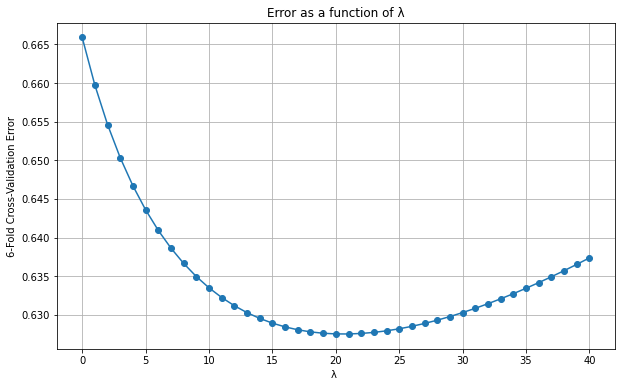

In [46]:
# Exercise 4 FIGURE ---------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lambda_pos, lambda_results_averaged, marker='o', linestyle='-')
plt.xlabel('λ ')
plt.ylabel('6-Fold Cross-Validation Error')
plt.title('Error as a function of λ')
plt.grid(True)
plt.show();


# Question 4 
On trouve que le $\lambda$ donnant les meilleurs résultats en moyenne est $\lambda$ = 21 grâce à la validation croisée.
Cependant relancer l'apprentissage peut donner des variations de valeurs.

La performance avec cette valeur de $\lambda$ est comparable à celle du meilleur sous-ensemble, mais avec l'avantage d'utiliser toutes les caractéristiques tout en contrôlant leur importance grâce à la régularisation. 

La régularisation est bénéfique pour ce jeu de données. Cela peut être dû à la corrélation entre certaines caractéristiques, et la régularisation aide à atténuer les effets de cette multicollinéarité.